In [1]:
import polars as pl
import matplotlib.pyplot as plt
import datetime as dt

from factor_momentum import construct_asset_signal

/home/boobus/projects/factor_momentum/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-13 10:33:13,935	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
start = dt.date(2000, 1, 1)
end = dt.date(2024, 1, 1)
signals = construct_asset_signal(start=start, end=end, type='rolling')


monthly_signal = signals.with_columns(
    ((pl.col('market_cap')/pl.col('market_cap').sum().over('month')) * pl.col('ret')).alias('wret')
)
monthly_signal

month,barrid,ret,market_cap,signal,wret
date,str,f64,f64,f64,f64
2013-07-01,"""USA06Z1""",-0.001596,6.006157e8,-0.001922,-4.8347e-8
2013-08-01,"""USA06Z1""",-0.014481,5.9463375e8,-0.000982,-4.4867e-7
2013-09-01,"""USA06Z1""",-0.391781,4.0188375e8,-0.000542,-0.000008
2013-10-01,"""USA06Z1""",0.23979,5.174708e8,-0.00036,0.000006
2013-11-01,"""USA06Z1""",0.172845,6.071625e8,0.000721,0.000005
…,…,…,…,…,…
2023-11-01,"""USBPJV1""",-0.024171,2.3905e8,-0.001981,-1.2341e-7
2023-12-01,"""USBPJV1""",0.140255,2.6725e8,-0.000219,7.6156e-7
2023-11-01,"""USBPKS1""",-0.038048,6.0244e7,-0.003623,-4.8956e-8


In [4]:
benchmark = monthly_signal.group_by(['month']).agg(
    pl.col('wret').sum()
).sort('month')

benchmark

month,wret
date,f64
2001-01-01,0.052486
2001-02-01,-0.085166
2001-03-01,-0.061744
2001-04-01,0.085644
2001-05-01,0.011485
…,…
2023-08-01,-0.017142
2023-09-01,-0.047633
2023-10-01,-0.024596


In [63]:
binned = (monthly_signal.with_columns(
    pl.col('signal').rank('dense').over('month').alias('rank')
)
.with_columns(
    (pl.lit("p") +
    (pl.col('rank')/pl.col('rank').count().over('month')*10 - 0.0001)
    .floor()
    .cast(pl.Int32).cast(pl.Utf8))
    .alias('bin')
)
.group_by(['month', 'bin']).agg(
    pl.col('wret').sum().alias('wret')*10,
    pl.col('ret').mean().alias('ret'),
    pl.col('wret').count().alias('count')
)
.sort(['bin', 'month'])
)

ports_ew = (binned
.pivot(on='bin', index='month', values='ret')
.drop_nulls()
)

ports_vw = (binned
.pivot(on='bin', index='month', values='wret')
.drop_nulls()
)

ports_vw

month,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01,0.01977,0.079456,0.054897,0.134018,0.002387,0.071557,0.072059,0.047266,0.025618,0.017834
2001-02-01,-0.029365,-0.120767,-0.253819,-0.294561,-0.107124,-0.037013,-0.009276,-0.003014,-0.002498,0.005782
2001-03-01,-0.011694,-0.043504,-0.125128,-0.100453,-0.111521,-0.122198,-0.053419,-0.02431,-0.0199,-0.005315
2001-04-01,0.00699,0.114392,0.233674,0.246274,0.100509,0.050022,0.033518,0.026267,0.027054,0.017744
2001-05-01,-0.003752,-0.015157,-0.002517,0.017218,0.042598,0.029696,0.017765,0.012573,0.010761,0.005667
…,…,…,…,…,…,…,…,…,…,…
2023-08-01,-0.004241,-0.008136,-0.013312,-0.015721,-0.030233,-0.011779,-0.013105,-0.031189,-0.029571,-0.014134
2023-09-01,-0.002882,-0.003338,-0.005692,-0.011643,-0.014856,-0.029582,-0.030783,-0.039475,-0.06074,-0.277342
2023-10-01,-0.003259,-0.000815,-0.006769,-0.001338,-0.022465,-0.031037,-0.033407,-0.034666,-0.039865,-0.072336


In [64]:
def plot_deciles(df, name, cum_sum=True):
    plt.figure(figsize=(8, 5))
    plt.title(name)
    dates = df['month']

    for i in range(10):
        if cum_sum:
            plt.plot(dates, df[f'p{i}'].cum_sum(),label = f'p{i}')
        else:
            plt.plot(dates, df[f'p{i}'],label = f'p{i}')
            
    plt.legend()
    plt.show()

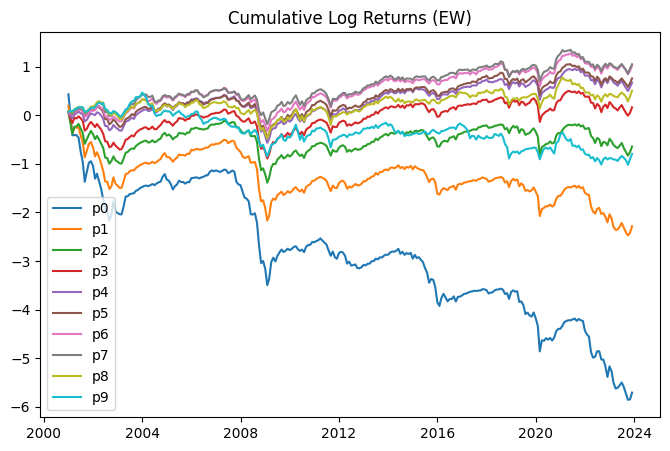

In [65]:
plot_deciles(ports_ew, "Cumulative Log Returns (EW)")

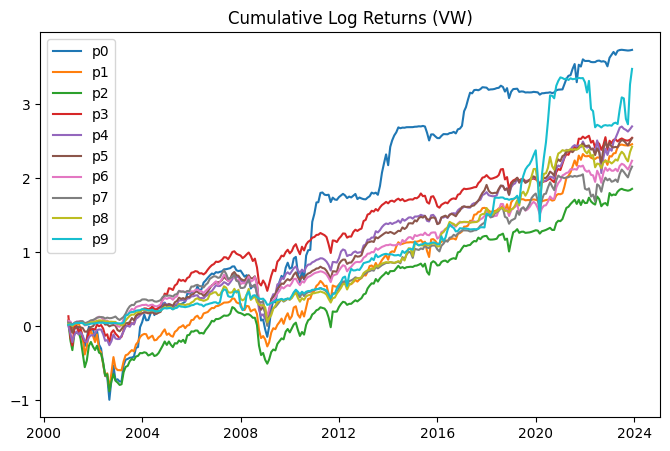

In [66]:
plot_deciles(ports_vw, "Cumulative Log Returns (VW)")

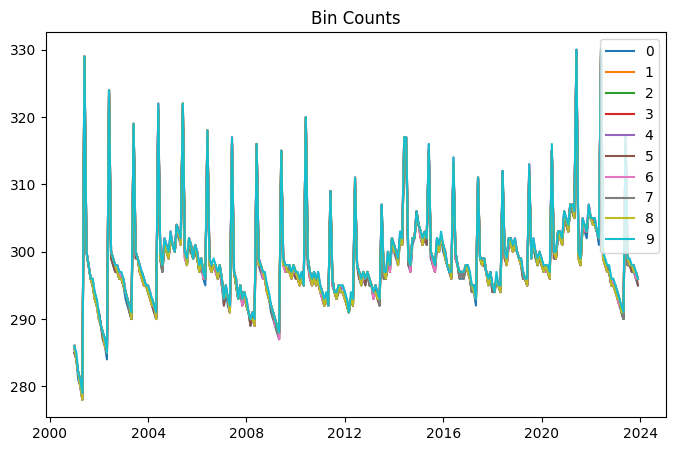

In [45]:
counts = (binned.pivot(
    on='bin', index='month', values='count'
)
)

plt.figure(figsize=(8, 5))
plt.title("Bin Counts")

for i in range(10):
    plt.plot(dates, counts[f'p{i}'], label = f'{i}')

plt.legend()
plt.show()

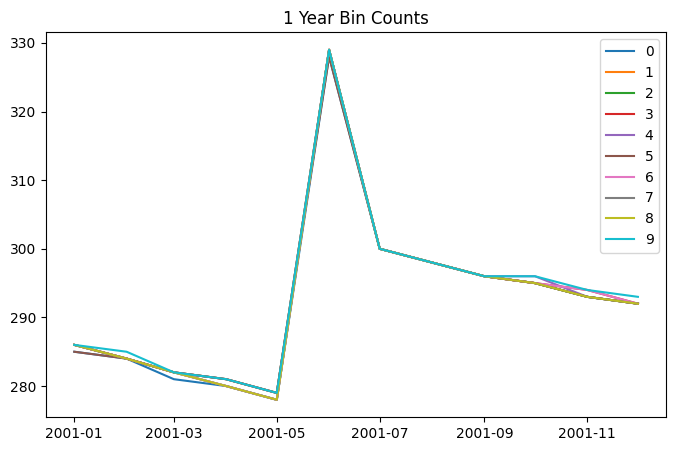

In [43]:
plt.figure(figsize=(8, 5))
plt.title("1 Year Bin Counts")

for i in range(10):
    plt.plot(dates[:12], counts[f'p{i}'][:12], label = f'{i}')

plt.legend()
plt.show()